<a href="https://colab.research.google.com/github/tanghuakang/A-SMD-Based-Domain-Adaptive-Change-Detection-Method/blob/main/SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image enhancement

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
tfds = tf.keras.datasets.mnist

In [ ]:
(train_img, train_label), (test_img, test_label) = tfds.load_data()

In [ ]:
train_img.shape

(60000, 28, 28)

In [ ]:
type(train_img[0])

numpy.ndarray

# SENet import channel

16feature maps + 3 difference maps

In [ ]:
import glob
import re
import tensorflow as tf

In [ ]:
img1_path = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one/*.png")
img2_path = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two/*.png")
label_path = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/ground_truth/*.png")
img_chazhi = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub/*.png")

In [ ]:
img1_path = sorted(img1_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
img2_path = sorted(img2_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
label_path = sorted(label_path,key = lambda i:int(re.search(r'(\d+)',i).group()))
img_chazhi = sorted(img_chazhi,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
img_chazhi

['E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\0.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\1.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\2.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\3.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\4.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\5.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\6.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\7.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub\\

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img1_path, img2_path, label_path, img_chazhi))

In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 30
step_per_epoch = 42//BATCH_SIZE

In [ ]:
auto = tf.data.experimental.AUTOTUNE

In [ ]:
dataset_train = dataset.map(compute_SENet_input, num_parallel_calls=auto)

In [ ]:
def read_img(img_path):
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    
    return img

def read_label(label_path):
    
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    
    return label

def compute_SENet_input(img1_path, img2_path, label_path, img_chazhi):
    img1 = read_img(img1_path)
    img2 = read_img(img2_path)
    label = read_label(label_path)
    chazhi = read_img(img_chazhi)
    
    img1 = tf.cast(img1, tf.float32)/255.0 
    img2 = tf.cast(img2, tf.float32)/255.0 
    label = tf.cast(label, tf.float32)/255.0 
    chazhi = tf.cast(chazhi, tf.float32)/255.0
    
    img_pred1 = model.predict(img1)
    img_pred2 = model.predict(img2)
    
    img_FD = tf.subtract(img_pred1, img_pred2)
    img_FD = tf.abs(img_FD)
    
    SENet_input_img = tf.concat([img_FD, img_chazhi], axis=-1)
    
    return SENet_input_img

# SENet测试 

In [ ]:
import tensorflow as tf
import numpy as np

class Squeeze_excitation_layer(tf.keras.Model):
    def __init__(self, filter_sq):
        super().__init__()
        self.filter_sq = filter_sq
        self.avepool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(filter_sq)
        self.relu = tf.keras.layers.Activation('relu')
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        squeeze = self.avepool(inputs)

        excitation = self.dense(squeeze)
        excitation = self.relu(excitation)
        excitation = tf.keras.layers.Dense(inputs.shape[-1])(excitation)
        excitation = self.sigmoid(excitation)
        excitation = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(excitation)

        scale = inputs * excitation

        return scale

SE = Squeeze_excitation_layer(16)
inputs = np.zeros([1, 32, 32, 32], dtype=np.float32)

In [ ]:
def SE_Net():
    inputs = tf.keras.layers.Input(shape=(256, 256, 19))
    
    x = tf.keras.layers.Conv2D(10, 1, padding='same', activation='relu')(inputs)
    x = Squeeze_excitation_layer(10)(x)
    output = tf.keras.layers.Conv2D(2, 1, padding='same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
SE_Net = SE_Net()

In [ ]:
SE_Net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 19)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 10)      200       
_________________________________________________________________
squeeze_excitation_layer_16  (None, 256, 256, 10)      110       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 2)       22        
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inputs = tf.convert_to_tensor(inputs)

In [ ]:
SE(inputs)

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'squeeze_excitation_layer_11_1/mul:0' shape=(1, 32, 32, 32) dtype=float32>

In [ ]:
import tensorflow as tf

class SEBottleneck(tf.keras.Model):
    def __init__(self, stride=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=1)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(16, kernel_size=3, strides=stride, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(32, kernel_size=1)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.se = Squeeze_excitation_layer(16)

    def call(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        out += residual
        out = self.relu(out)

        return out

SEB = SEBottleneck()
inputs = np.zeros((1, 32, 32, 32), dtype=np.float32)
inputs = tf.convert_to_tensor(inputs)
SEB(inputs).shape


TensorShape([Dimension(1), Dimension(32), Dimension(32), Dimension(32)])

In [ ]:
type(inputs)

numpy.ndarray

In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(train_img, train_label) , (test_img, test_label) = mnist.load_data()

In [ ]:
train_img, test_img = train_img / 255.0, test_img / 255.0

In [ ]:
train_img = np.expand_dims(train_img, -1)

In [ ]:
train_img.shape

(60000, 28, 28, 1)

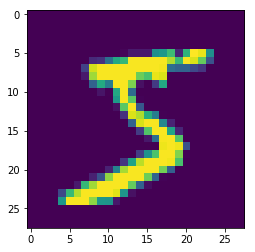

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_img[0])
# plt.imshow()

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_img, train_label))

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_img, test_label))

In [ ]:
train_data = train_data.batch(32)

In [ ]:
train_data.take(9)

<DatasetV1Adapter shapes: ((?, 28, 28, 1), (?,)), types: (tf.float64, tf.uint8)>

In [ ]:
def model():
    inputs = tf.keras.layers.Input(shape=(28,28,1))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu')(inputs)
    x1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    x2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(x1)
    
    x3 = tf.keras.layers.Dense(10, activation='softmax')(x2)
    
    return tf.keras.Model(inputs=inputs, outputs=x3)

In [ ]:
model = model()

In [ ]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
epochs = 5
steps_per_epoch = 60000//32

In [ ]:
model.fit(train_data,
          epochs=5,
          steps_per_epoch=1870
          )

Epoch 1/5


InvalidArgumentError: Incompatible shapes: [32] vs. [32,22,22]
	 [[{{node metrics_2/acc/Equal}}]]
	 [[{{node metrics_2/acc/div_no_nan}}]]

In [ ]:
import glob

In [ ]:
img1_path = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\im_one/*.png")

In [ ]:
img1_path

['E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\0.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\1.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\10.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\11.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\12.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\13.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\14.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\15.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Ti

In [ ]:
img2_path = glob.glob("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\im_two/*.png")

In [ ]:
img2_path

['E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\0.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\1.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\10.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\11.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\12.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\13.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\14.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\15.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Ti

In [ ]:
import re
img1_path = sorted(img1_path,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
img1_path

['E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\0.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\1.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\2.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\3.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\4.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\5.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\6.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_one\\7.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob

In [ ]:
img2_path = sorted(img2_path,key = lambda i:int(re.search(r'(\d+)',i).group()))

In [ ]:
img2_path

['E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\0.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\1.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\2.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\3.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\4.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\5.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\6.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png\\im_two\\7.png',
 'E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob

In [ ]:
def read_img(img_path):
    img = plt.imread(img_path)
    img = img[:,:,:3]
    return img

In [ ]:
img1 = read_img("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two/2.png")

In [ ]:
img2 = read_img("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one/2.png")

In [ ]:
img_2_new = np.abs(img1-img2)

In [ ]:
import matplotlib
matplotlib.image.imsave("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub/"+str(555)+".png", img_2_new)

In [ ]:
img_555 = plt.imread("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/two_png_sub/555.png")

In [ ]:
img_555[:10]

array([[[0.5372549 , 0.34509805, 0.34117648, 1.        ],
        [0.4745098 , 0.2901961 , 0.27058825, 1.        ],
        [0.12941177, 0.10588235, 0.14117648, 1.        ],
        ...,
        [0.10980392, 0.        , 0.03921569, 1.        ],
        [0.10980392, 0.01568628, 0.05882353, 1.        ],
        [0.04705882, 0.09019608, 0.08627451, 1.        ]],

       [[0.33333334, 0.14901961, 0.15686275, 1.        ],
        [0.30588236, 0.15686275, 0.1764706 , 1.        ],
        [0.13725491, 0.01176471, 0.01568628, 1.        ],
        ...,
        [0.13725491, 0.01568628, 0.01960784, 1.        ],
        [0.07058824, 0.09019608, 0.09411765, 1.        ],
        [0.03137255, 0.1254902 , 0.10588235, 1.        ]],

       [[0.15686275, 0.16078432, 0.1764706 , 1.        ],
        [0.06666667, 0.00392157, 0.04705882, 1.        ],
        [0.02745098, 0.04705882, 0.07058824, 1.        ],
        ...,
        [0.07450981, 0.07058824, 0.05882353, 1.        ],
        [0.08235294, 0.062745

In [ ]:
img_2_new[:10]

array([[[0.54117644, 0.34509805, 0.34117648],
        [0.4745098 , 0.29411763, 0.27058825],
        [0.13333333, 0.10980392, 0.14509803],
        ...,
        [0.10980393, 0.00392157, 0.04313725],
        [0.10980392, 0.01960784, 0.05882354],
        [0.05098039, 0.09411764, 0.08627452]],

       [[0.33333334, 0.15294117, 0.1607843 ],
        [0.30588236, 0.1607843 , 0.18039215],
        [0.14117646, 0.01568627, 0.01960784],
        ...,
        [0.14117646, 0.01960784, 0.01960786],
        [0.07058824, 0.09411764, 0.09411766],
        [0.03529412, 0.12941176, 0.10588236]],

       [[0.1607843 , 0.16470587, 0.18039215],
        [0.07058823, 0.00784314, 0.05098039],
        [0.03137255, 0.05098039, 0.0745098 ],
        ...,
        [0.07450981, 0.07058825, 0.05882354],
        [0.0862745 , 0.06666666, 0.08627452],
        [0.06274511, 0.09019607, 0.09803922]],

       ...,

       [[0.37647057, 0.3215686 , 0.34509805],
        [0.28235292, 0.2352941 , 0.22745097],
        [0.16862744, 0

In [ ]:
for i,j,k in zip(img1_path, img2_path, range(42)):
    print(i)
    print(j)
    print(type(k))

E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one\0.png
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two\0.png
<class 'int'>
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one\1.png
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two\1.png
<class 'int'>
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one\2.png
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two\2.png
<class 'int'>
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one\3.png
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_two\3.png
<class 'int'>
E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Szada/Szada_sub_png/im_one\4.png
E:/RS_datasets/SZTAKI_AirC

In [ ]:
import matplotlib
for i,j,k in zip(img1_path, img2_path, range(30)):
    img1 = read_img(i)
    img2 = read_img(j)
    img_new = np.abs(img1-img2)
    matplotlib.image.imsave("E:/RS_datasets/SZTAKI_AirChange_Benchmark/SZTAKI_AirChange_Benchmark/Tiszadob/Tiszadob_sub_png/two_png_sub/"+str(k)+".png", img_new)